In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from scipy.interpolate import make_interp_spline


## Datacenter GPU plots

### Chip Metrics Plot
**Tot CFP, Mfg CFP%, Ope CFP%,  CPFA, Process Node, DieSize**

In [2]:
def set_plot_ax(ax):
    ax.yaxis.label.set_size(14)
    ax.yaxis.label.set_fontweight('bold')
    ax.xaxis.label.set_size(14)
    ax.xaxis.label.set_fontweight('bold')
    ax.title.set_fontsize(16)
    ax.title.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontsize(12)
        label.set_fontweight('bold')

    for tick in ax.get_xticklabels():
        # tick.set_rotation(15)
        tick.set_fontsize(12)
        tick.set_fontweight('bold')

    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(12)  


In [3]:
def fake_arr(arr):

    fake = np.zeros(len(arr) * 2 - 1)
    for i in range(len(arr)):
        fake[i * 2] = arr[i]
        if i < len(arr) - 1:
            fake[i * 2 + 1] = (arr[i] + arr[i + 1]) / 2

    return fake

fake_arr([1, 2, 3, 4, 5])

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [4]:
def fake_arr2(arr):
    # First iteration: Double the points by adding midpoints
    fake = np.zeros(len(arr) * 2 - 1)
    for i in range(len(arr)):
        fake[i * 2] = arr[i]
        if i < len(arr) - 1:
            fake[i * 2 + 1] = (arr[i] + arr[i + 1]) / 2
    
    # Second iteration: Double the points again by adding midpoints
    result = np.zeros(len(fake) * 2 - 1)
    for i in range(len(fake)):
        result[i * 2] = fake[i]
        if i < len(fake) - 1:
            result[i * 2 + 1] = (fake[i] + fake[i + 1]) / 2
    
    return result


fake_arr2([1, 2, 3, 4, 5])

array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
       3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])

In [5]:
def performance_metric_plot(nv, server=True):
    # Define style constants for easy tuning
    FACTOR = 2
    TITLE_FONT_SIZE = 22 * FACTOR
    LABEL_FONT_SIZE = 18 * FACTOR
    TICK_FONT_SIZE = 14 * FACTOR
    AXIS_LABEL_FONT_SIZE = 16 * FACTOR
    LEGEND_FONT_SIZE = 15 * FACTOR
    LINE_WIDTH = 5 * FACTOR
    MARKER_SIZE = 10 * FACTOR
    GRID_ALPHA = 0.2
    LABEL_COLOR = '#4a4a4a'
    # Colors from the provided palette
    COLOR_1 = '#E63946'  # Bright red
    COLOR_2 = '#F4A261'  # Vivid orange
    COLOR_4 = '#4583B6'  # Rich navy blue for contrast
    COLOR_5 = '#76C776'  # Bright warm yellow-orange
    
    SPLINE = 3

    # Plot and axis labels
    plot_title = 'Datacenter GPUs Normalized Performance Efficiency' if server else 'Desktop GPUs Normalized Performance Efficiency'
    x_label = 'NVIDIA Datacenter GPUs' if server else 'NVIDIA Desktop GPUs'

    # Auto-set figure size based on input data
    fig_width = 20  # Set a minimum width of 10, scale with number of products
    fig_height = 12 # Fixed height for better readability

    # Create figure and main axis
    fig1, ax1 = plt.subplots(figsize=(fig_width, fig_height))
    # ax1.set_title(plot_title, fontsize=TITLE_FONT_SIZE, fontweight='bold', color=LABEL_COLOR, pad=20)
    # ax1.set_xlabel(x_label, fontsize=LABEL_FONT_SIZE, fontweight='bold', color=LABEL_COLOR, labelpad=15)

    # Adjust spacing to avoid overlap
    plt.subplots_adjust(top=0.85, bottom=0.1, left=0.1, right=0.9, hspace=0.3)

    # Prepare data
    x_data_fake = fake_arr(np.arange(len(nv['Product'])))  # Using indices for smooth interpolation
    x_data_fake2 = fake_arr2(np.arange(len(nv['Product'])))  # Using indices for smooth interpolation

    x_data = np.arange(len(nv['Product']))  # Using indices for smooth interpolation
    x_labels = nv['Product']  # Original product labels
    x_smooth = np.linspace(x_data.min(), x_data.max(), 500)  # Smoother x-axis

    # OpenCL Score (smoothened line with original markers)
    y_opencl_score_fake = fake_arr2(nv['OpenCL Score'])
    y_opencl_score = nv['OpenCL Score']
    spline_opencl = make_interp_spline(x_data_fake2, y_opencl_score_fake, k=SPLINE)
    y_opencl_smooth = spline_opencl(x_smooth)
    score_color = COLOR_5
    ax1.set_ylabel('Normalized Factor', fontsize=AXIS_LABEL_FONT_SIZE, fontweight='bold', color=LABEL_COLOR)
    ax1.plot(x_smooth, y_opencl_smooth, label='Performance', color=score_color, linewidth=LINE_WIDTH)
    ax1.plot(x_data, y_opencl_score, 'D', markersize=MARKER_SIZE, color=score_color, alpha=0.8)  # Plot markers at original points

    # Performance / Total CFP (plotted on the same axis as Performance)
    cfp_color = COLOR_4
    y_opencl_cfp_fake = fake_arr2(nv['OpenCL Score / CFP'])
    y_opencl_cfp = nv['OpenCL Score / CFP']
    spline_opencl_cfp = make_interp_spline(x_data_fake2, y_opencl_cfp_fake, k=SPLINE)
    y_opencl_cfp_smooth = spline_opencl_cfp(x_smooth)
    ax1.plot(x_smooth, y_opencl_cfp_smooth, label='Performance / CFP', color=cfp_color, linewidth=LINE_WIDTH)
    ax1.plot(x_data, y_opencl_cfp, 'D', markersize=MARKER_SIZE, color=cfp_color, alpha=0.8)

    # Performance / Embodied CFPA (smoothened line with original markers)
    transistor_color = COLOR_2
    y_trans_score_fake = fake_arr(nv['OpenCL Score / Embodied CFPA'])
    y_trans_score = nv['OpenCL Score / Embodied CFPA']
    spline_trans_score = make_interp_spline(x_data_fake, y_trans_score_fake, k=SPLINE)
    y_trans_score_smooth = spline_trans_score(x_smooth)
    ax1.plot(x_smooth, y_trans_score_smooth, label='Performance / Embodied CFPA', linestyle='--', color=transistor_color, linewidth=LINE_WIDTH)
    ax1.plot(x_data, y_trans_score, 'D', markersize=MARKER_SIZE, color=transistor_color, alpha=0.8)

    # Axis configuration
    ax1.set_xticks(x_data)  # Set x-ticks to original positions
    ax1.set_xticklabels(x_labels, fontsize=TICK_FONT_SIZE, fontweight='bold', color=LABEL_COLOR)
    ax1.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE, colors=LABEL_COLOR)
    if not server:
        ax1.tick_params(axis='x', rotation=15)

    # Add a light grid for better readability
    ax1.grid(visible=True, linestyle='--', linewidth=1, alpha=GRID_ALPHA)

    # Spine settings
    # ax1.spines['left'].set_color(score_color)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['left'].set_position(('outward', 20))
    ax1.spines['bottom'].set_linewidth(2)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    # Set tick labels to be bold for the left y-axis (OpenCL Score)
    for label in ax1.get_yticklabels():
        # label.set_color(score_color)
        label.set_fontweight('bold')
        label.set_fontsize(TICK_FONT_SIZE)

    # Release Date (Secondary X Axis)
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim()[0] - 0.1, ax1.get_xlim()[1])  # Extend the range at the start for separation
    ax2.set_xticks(x_data)
    ax2.set_xlabel('Release Year', fontsize=AXIS_LABEL_FONT_SIZE, fontweight='bold', color=LABEL_COLOR, labelpad=10)
    ax2.set_xticklabels(nv['Release Date'], fontsize=TICK_FONT_SIZE, fontweight='bold', color=LABEL_COLOR)
    ax2.spines['top'].set_linewidth(2)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # Process Node (Tertiary X Axis)
    ax3 = ax1.twiny()
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xticks(x_data)
    ax3.set_xlabel('Process Node(nm)', fontsize=AXIS_LABEL_FONT_SIZE, fontweight='bold', color=LABEL_COLOR, labelpad=10)
    ax3.set_xticklabels(nv['Process Size (nm)'], fontsize=TICK_FONT_SIZE, fontweight='bold', color=LABEL_COLOR)
    ax3.tick_params(axis='x', labelsize=TICK_FONT_SIZE)    
    ax3.spines['top'].set_linewidth(2)
    ax3.spines['top'].set_linewidth(2)
    ax3.spines['top'].set_position(('outward', 80))
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    # Re-apply settings to ensure font size is correctly applied
    for label in ax3.get_xticklabels():
        label.set_fontsize(TICK_FONT_SIZE)
        label.set_fontweight('bold')
        label.set_color(LABEL_COLOR)

    # Embodied CFP per unit area (smoothened line with original markers)
    y_cpfa_fake = fake_arr(nv['Embodied CFP per unit area'])
    y_cpfa = nv['Embodied CFP per unit area']
    spline_cpfa = make_interp_spline(x_data_fake, y_cpfa_fake, k=SPLINE)
    y_cpfa_smooth = spline_cpfa(x_smooth)
    cpfa_color = COLOR_1
    ax4 = ax1.twinx()
    ax4.set_ylabel(r'Embodied CFPA $(g\ CO_2\ e.q. /mm^2)$', fontsize=AXIS_LABEL_FONT_SIZE, fontweight='bold', color=cpfa_color, labelpad=15)
    ax4.plot(x_smooth, y_cpfa_smooth, label='Embodied CFPA', linestyle='--',color=cpfa_color, linewidth=LINE_WIDTH)
    ax4.plot(x_data, y_cpfa, 'D', markersize=MARKER_SIZE, color=cpfa_color, alpha=0.8)
    ax4.spines['right'].set_color(cpfa_color)
    ax4.spines['right'].set_linewidth(2)
    ax4.spines['right'].set_position(('outward', 30))
    ax4.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.set_ylim(ax4.get_ylim()[0], ax4.get_ylim()[1] * 1.1)  # Extend the range for separation

    for label in ax4.get_yticklabels():
        label.set_color(cpfa_color)
        label.set_fontweight('bold')
        label.set_fontsize(TICK_FONT_SIZE)

    # Add legend
    fig1.legend(loc='upper center', fontsize=AXIS_LABEL_FONT_SIZE, frameon=False, ncol=1, bbox_to_anchor=(0.3, 0.8))

    return fig1


In [6]:
def chip_metrics_plot(nv, server=True):
    # Define style constants for easy tuning
    FACTOR = 2
    TITLE_FONT_SIZE = 22 * FACTOR
    LABEL_FONT_SIZE = 18 * FACTOR
    TICK_FONT_SIZE = 14 * FACTOR
    AXIS_LABEL_FONT_SIZE = 16 * FACTOR
    LEGEND_FONT_SIZE = 15 * FACTOR
    LINE_WIDTH = 5 * FACTOR
    MARKER_SIZE = 10 * FACTOR
    GRID_ALPHA = 0.2
    LABEL_COLOR = '#4a4a4a'


    SPLINE = 2
    
    # Colors from the provided palette
    COLOR_2 = '#D62728'  # Orange-yellow
    COLOR_5 = '#248F24'  
    COLOR_6 = '#4583B6'

    plot_title = 'Datacenter GPUs Sustainability Metrics' if server else 'Desktop GPUs Sustainability Metrics'
    x_label = 'NVIDIA Datacenter GPUs' if server else 'NVIDIA Desktop GPUs'

    # Create figure and main axis
    
    fig1, ax1 = plt.subplots(figsize=(20, 12))
    # ax1.set_title(plot_title, fontsize=TITLE_FONT_SIZE, fontweight='bold', color=LABEL_COLOR, pad=20)
    # ax1.set_xlabel(x_label, fontsize=LABEL_FONT_SIZE, fontweight='bold', color=LABEL_COLOR, labelpad=15)

    # Prepare data
    x_data_fake = fake_arr(np.arange(len(nv['Product'])))
    x_data_fake2 = fake_arr2(np.arange(len(nv['Product'])))
    x_data = np.arange(len(nv['Product']))  # Using indices for smooth interpolation
    x_labels = nv['Product']  # Original product labels
    x_smooth = np.linspace(x_data_fake.min(), x_data_fake.max(), 500)


    # Manufacture CFP percentage (smoothened line with original markers)
    y_mfg_cfp_fake = fake_arr(nv['Mfg CFP percentage'])
    y_mfg_cfp = nv['Mfg CFP percentage']
    spline_mfg = make_interp_spline(x_data_fake, y_mfg_cfp_fake, k=SPLINE)
    y_mfg_smooth = spline_mfg(x_smooth)
    ax1.set_ylabel(ylabel='CFP Percentage', fontsize=AXIS_LABEL_FONT_SIZE, fontweight='bold', color=COLOR_2)  
    ax1.plot(x_smooth, y_mfg_smooth, label='%ECFP', color=COLOR_2, linewidth=LINE_WIDTH)
    ax1.plot(x_data, y_mfg_cfp, 'D', markersize=MARKER_SIZE, color=COLOR_2, alpha=0.8)  # Plot markers at original points

    # Operational CFP percentage (smoothened line with original markers)
    y_ope_cfp = nv['Ope CFP percentage']
    spline_ope = make_interp_spline(x_data, y_ope_cfp, k=3)
    y_ope_smooth = spline_ope(x_smooth)
    ax1.plot(x_smooth, y_ope_smooth, label='%OCFP', color=COLOR_2, linestyle='--', linewidth=LINE_WIDTH)  # Orange-yellow
    ax1.plot(x_data, y_ope_cfp, 'D', markersize=MARKER_SIZE, color=COLOR_2, alpha=0.8)  # Plot markers at original points

    ax1.set_xticks(x_data)  # Set x-ticks to original positions
    ax1.set_xticklabels(x_labels, fontsize=TICK_FONT_SIZE, fontweight='bold', color=LABEL_COLOR)  # Set original product names as labels
    ax1.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE, colors=LABEL_COLOR)
    if not server:  
        ax1.tick_params(axis='x', rotation=15)
    # Add a light grid for better readability
    ax1.grid(visible=True, linestyle='--', linewidth=1, alpha=GRID_ALPHA)

    ax1.spines['left'].set_linewidth(2)
    ax1.spines['left'].set_color(COLOR_2)
    ax1.spines['left'].set_position(('outward', 20))

    ax1.spines['bottom'].set_linewidth(2)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    # Set tick labels to be bold for the left y-axis (CFP Percentage %)
    for label in ax1.get_yticklabels():
        label.set_color(COLOR_2)
        label.set_fontweight('bold')
        label.set_fontsize(TICK_FONT_SIZE)

    # Release Date (Secondary X Axis)
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(x_data)
    ax2.set_xlabel('Release Year', fontsize=AXIS_LABEL_FONT_SIZE, fontweight='bold', color=LABEL_COLOR, labelpad=10)
    ax2.set_xticklabels(nv['Release Date'], fontsize=TICK_FONT_SIZE, fontweight='bold', color=LABEL_COLOR)
    ax2.spines['top'].set_linewidth(2)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # Process Node (Tertiary X Axis)
    ax3 = ax1.twiny()
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xticks(x_data)
    ax3.set_xlabel('Process Node(nm)', fontsize=AXIS_LABEL_FONT_SIZE, fontweight='bold', color=LABEL_COLOR, labelpad=10)
    ax3.set_xticklabels(nv['Process Size (nm)'], fontsize=TICK_FONT_SIZE, fontweight='bold', color=LABEL_COLOR)
    ax3.spines['top'].set_linewidth(2)
    ax3.spines['top'].set_position(('outward', 80))
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)

# Re-apply settings to ensure font size is correctly applied
    for label in ax3.get_xticklabels():
        label.set_fontsize(TICK_FONT_SIZE)
        label.set_fontweight('bold')
        label.set_color(LABEL_COLOR)

    # Total CFP (smoothened line with original markers)
    cfp_color = COLOR_6  # Blue
    y_tot_cfp_fake = fake_arr(nv['Tot CFP'])
    y_tot_cfp = nv['Tot CFP']
    spline_tot_cfp = make_interp_spline(x_data_fake, y_tot_cfp_fake, k=SPLINE)
    y_tot_smooth = spline_tot_cfp(x_smooth)
    ax4 = ax1.twinx()
    ax4.set_ylabel(r'CFP $(kg\ CO_2e.q.)$', fontsize=AXIS_LABEL_FONT_SIZE, fontweight='bold', color=cfp_color, labelpad=15)
    ax4.plot(x_smooth, y_tot_smooth, label='Total CFP', color=cfp_color, linewidth=LINE_WIDTH)
    ax4.plot(x_data, y_tot_cfp, 'D', markersize=MARKER_SIZE, color=cfp_color, alpha=0.8)  # Plot markers at original points
    ax4.spines['right'].set_color(cfp_color)
    ax4.spines['right'].set_linewidth(2)
    ax4.spines['right'].set_position(('outward', 30))
    ax4.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)

    for label in ax4.get_yticklabels():
        label.set_color(cfp_color)
        label.set_fontweight('bold')
        label.set_fontsize(TICK_FONT_SIZE)

    # Die Size (smoothened line with original markers)
    die_color = COLOR_5  # Medium green
    y_die_size_fake = fake_arr(nv['DieSizeValue'])
    y_die_size = nv['DieSizeValue']
    spline_die_size = make_interp_spline(x_data_fake, y_die_size_fake, k=SPLINE)
    y_die_smooth = spline_die_size(x_smooth)
    ax6 = ax1.twinx()
    ax6.set_ylabel(r'Die Area($mm^2$)', fontsize=AXIS_LABEL_FONT_SIZE, fontweight='bold', color=die_color, labelpad=15)
    ax6.plot(x_smooth, y_die_smooth, label='Die Area', color=die_color, linewidth=LINE_WIDTH)
    ax6.plot(x_data, y_die_size, 'D', markersize=MARKER_SIZE, color=die_color, alpha=0.8)  # Plot markers at original points
    ax6.yaxis.set_label_position('left')
    ax6.yaxis.set_ticks_position('left')
    ax6.spines['left'].set_color(die_color)
    ax6.spines['left'].set_linewidth(2)
    ax6.spines['left'].set_position(('outward', 140))
    ax6.spines['right'].set_visible(False)
    ax6.spines['top'].set_visible(False)

    for label in ax6.get_yticklabels():
        label.set_color(die_color)
        label.set_fontweight('bold')
        label.set_fontsize(TICK_FONT_SIZE)

    # Add legend
    fig1.legend(loc='upper center', fontsize=AXIS_LABEL_FONT_SIZE, frameon=False, ncol=1, bbox_to_anchor=(0.3, 0.8))

    return fig1


In [7]:
nv = pd.read_csv('dataset/NVIDIA-Datacenter-GPU.csv')
nv['Mfg CFP percentage'] = nv['Mfg CFP'] / nv['Tot CFP']*100
nv['Ope CFP percentage'] = nv['Ope CFP'] / nv['Tot CFP']*100
nv['OpenCL Score'] = nv['OpenCL Score'] / nv['OpenCL Score'].min()
nv['OpenCL Score / Embodied CFPA'] = nv['OpenCL Score / Embodied CFPA']/nv['OpenCL Score / Embodied CFPA'].min()
nv['OpenCL Score / CFP'] = nv['OpenCL Score / CFP'] / nv['OpenCL Score / CFP'].min()

nv.head()

,Unnamed: 0,Product,Vendor,Release Date,Process Size (nm),TDP (W),DieSizeValue,Transistors (million),Mfg CFP,Ope CFP,...,Operational CFP per unit area,OpenCL Score,OpenCL Score / Embodied CFPA,OpenCL Score / million Trans,OpenCL Score / CFP,TFLOPS,Des CFP,OpenCL Score / Embodied CPFA,Mfg CFP percentage,Ope CFP percentage
0,0,K40,NVIDIA,2013,28,245,561,7080,7.701342,111.098873,...,198.03720,1.000000,1.000000,2.78,1.000000,5.04,0.369241,2356.3540,6.462513,93.227642
1,1,M40,NVIDIA,2015,28,250,601,8000,8.474066,113.366197,...,188.62929,1.993553,1.919833,4.91,1.943543,6.83,0.395568,4300.0360,6.932555,92.743835
2,2,P100-SXM,NVIDIA,2016,14,300,610,15300,11.630463,203.652401,...,333.85640,3.993502,2.623704,5.14,2.191875,10.60,1.838730,5371.4727,5.356659,93.796475
3,3,V100-SXM,NVIDIA,2017,14,300,815,21100,18.177794,203.652401,...,249.88025,8.909280,4.923880,8.32,4.733732,125.00,2.456664,8281.1500,8.104708,90.799970
4,4,A100-SXM,NVIDIA,2020,7,400,826,54200,61.955404,328.895529,...,398.17862,10.610011,1.756204,3.86,3.143250,312.00,11.404453,2758.5771,15.402007,81.762865


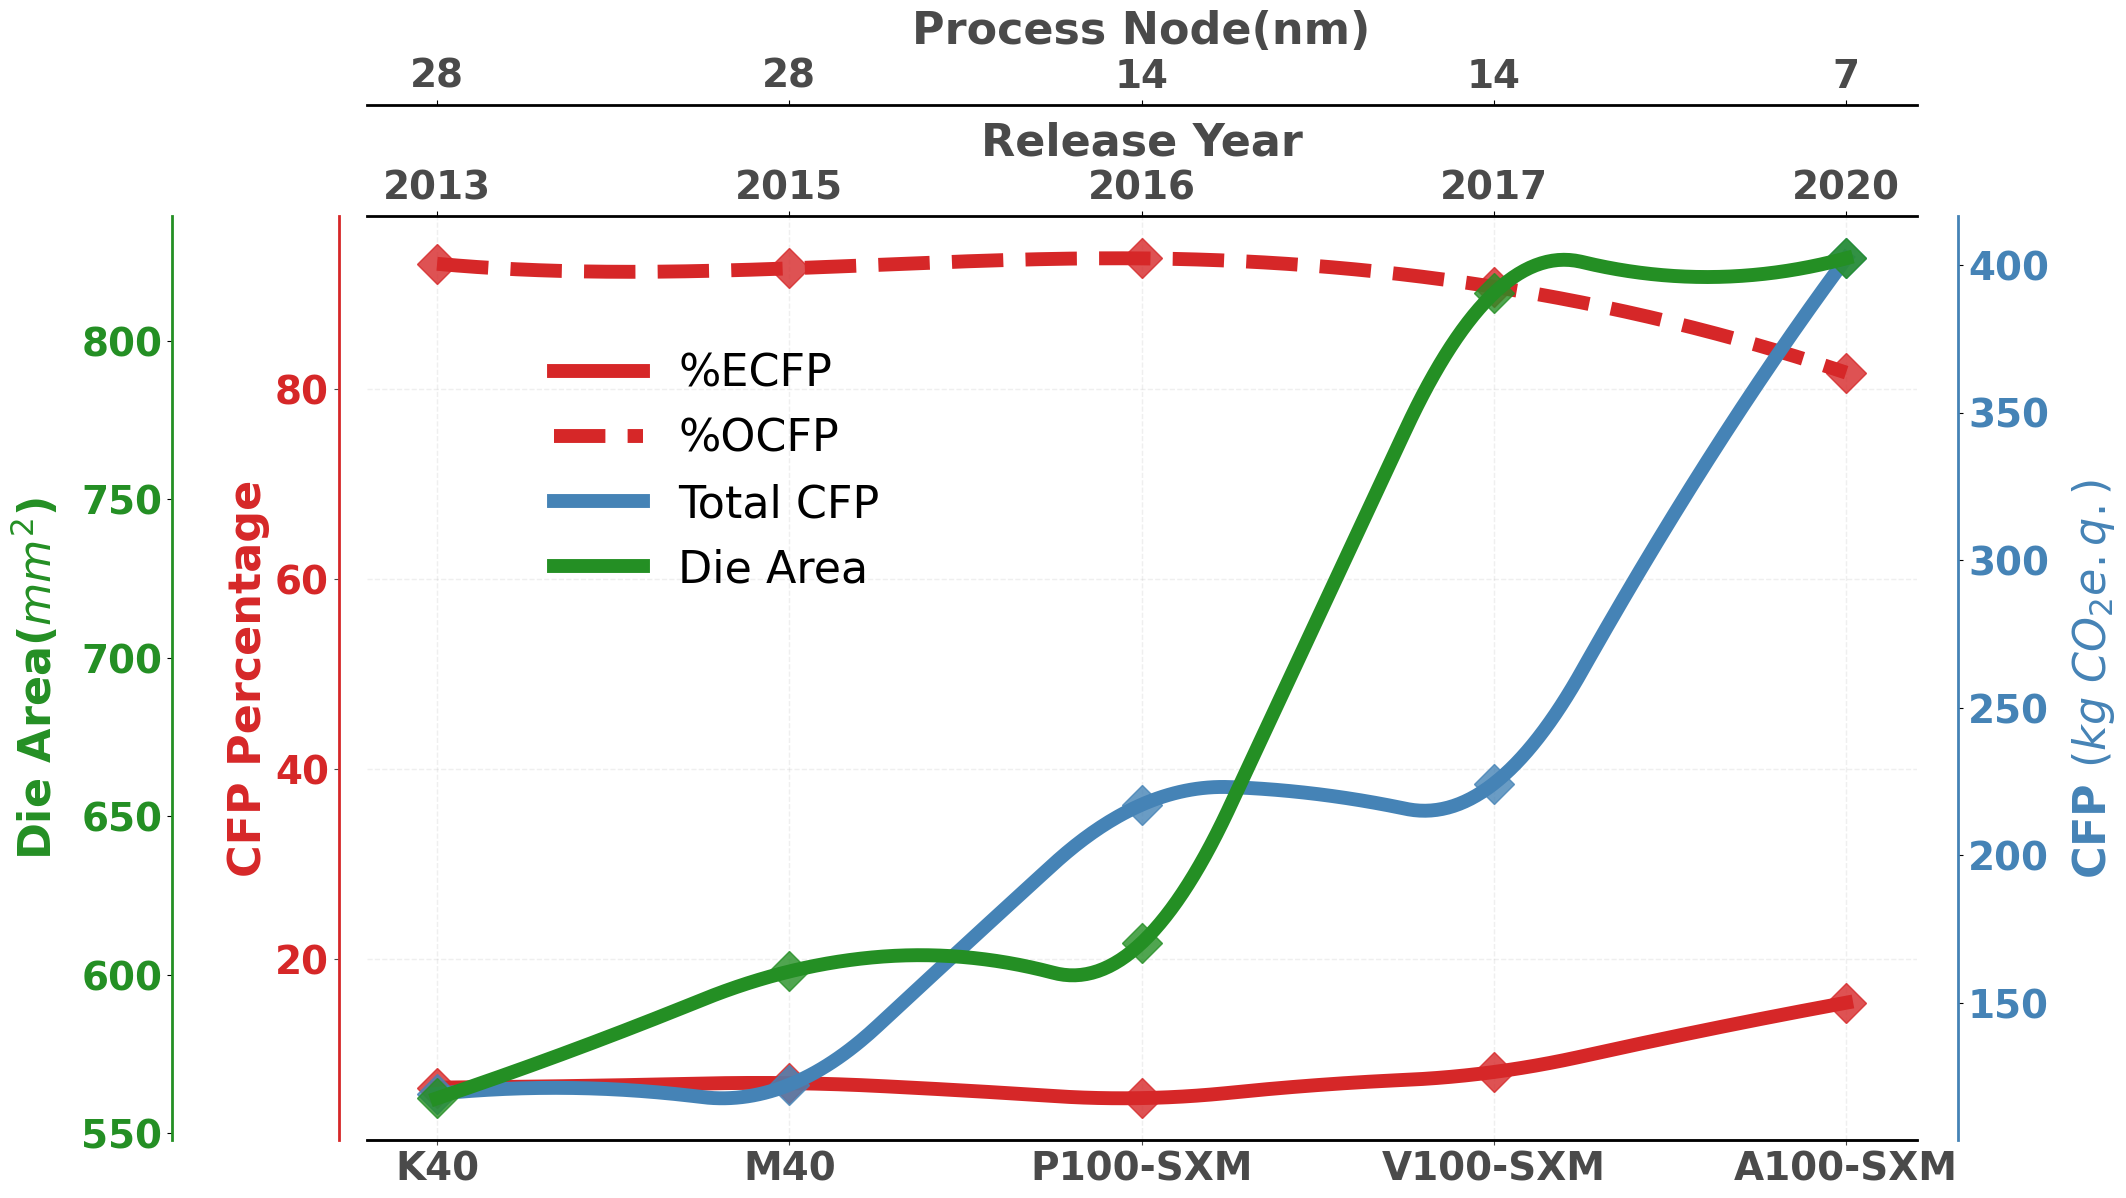

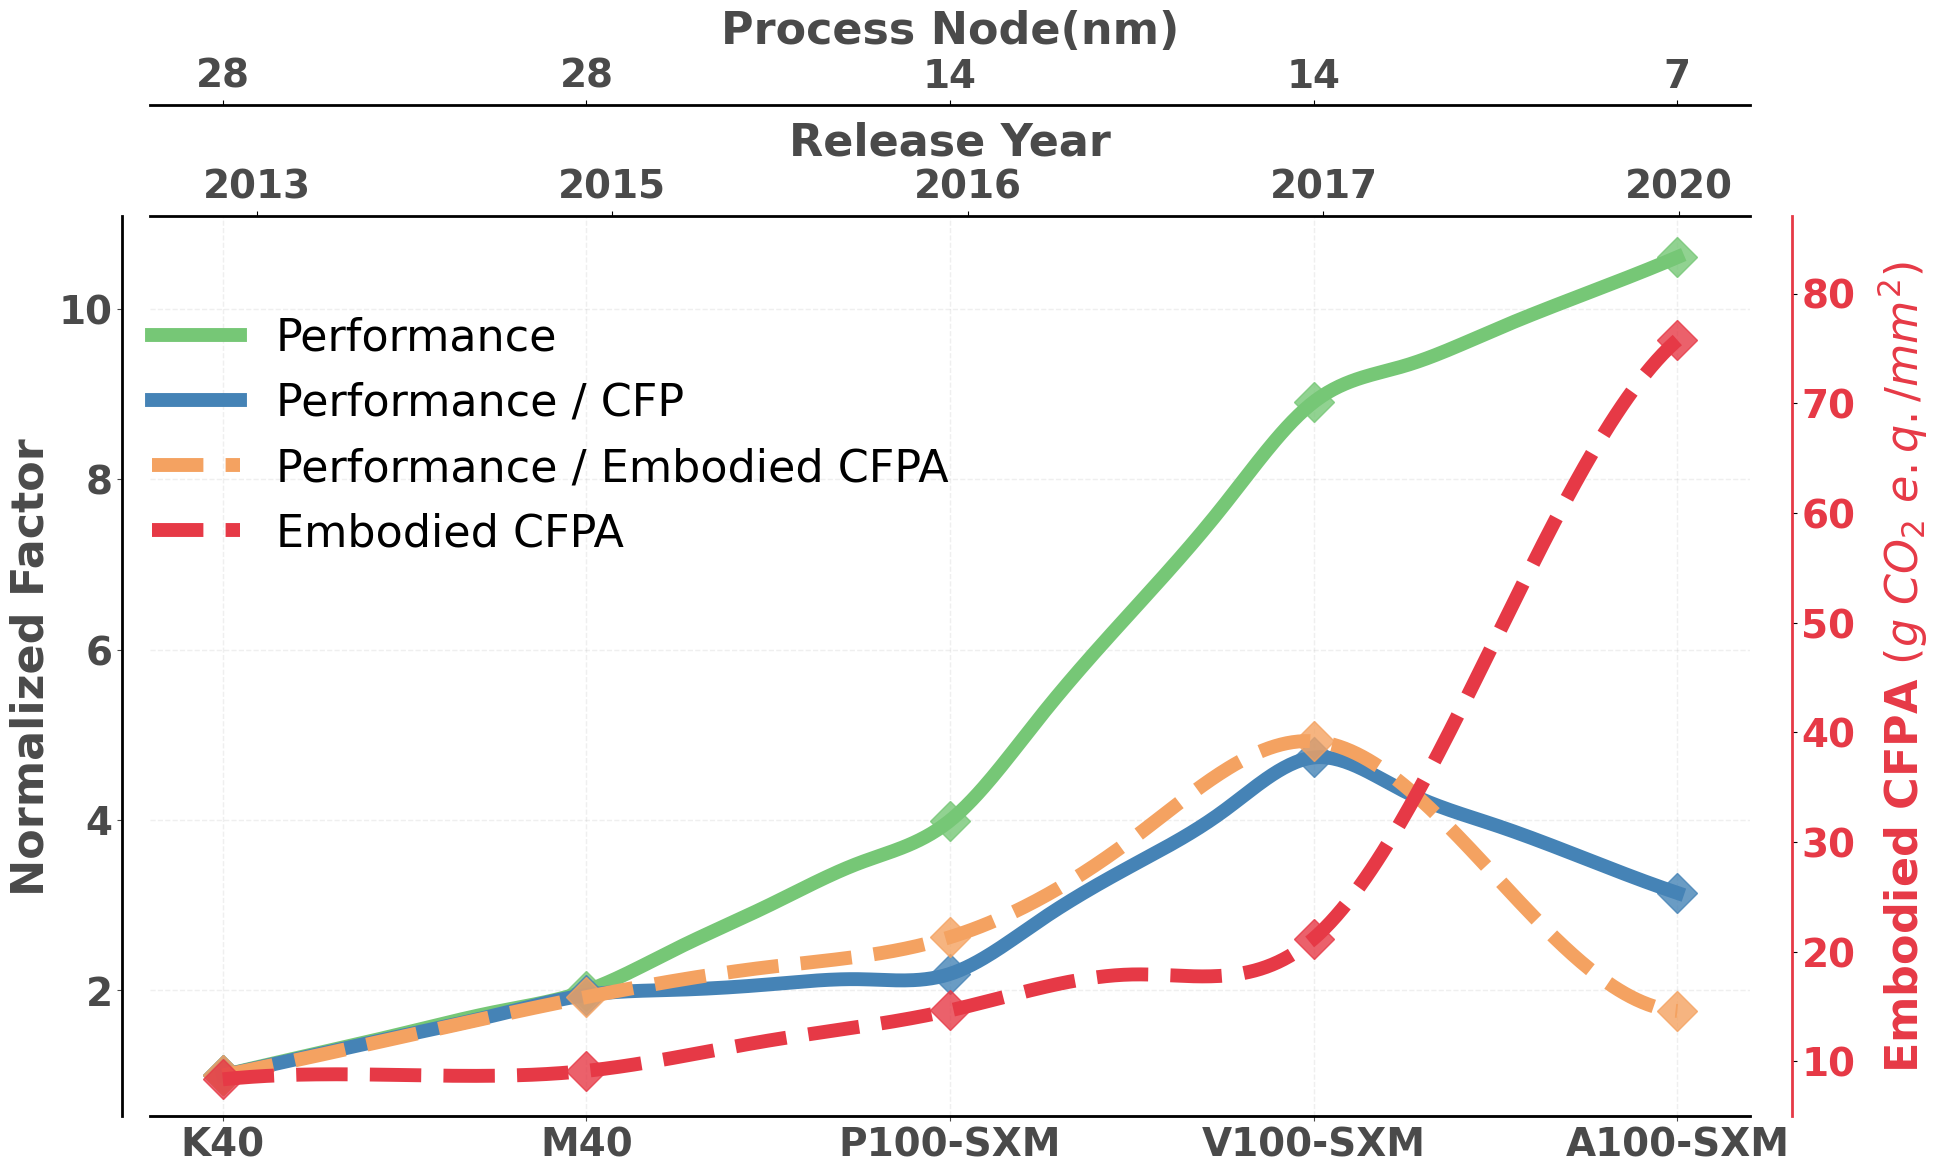

In [8]:
server_chip_metrics_plot = chip_metrics_plot(nv, server = True)
server_perf_fig = performance_metric_plot(nv, server = True)

server_chip_metrics_plot.savefig('server_GPU_chip_metrics_plot.pdf', dpi=300, bbox_inches='tight')
server_perf_fig.savefig('server_GPU_performance_metrics_plot.pdf', dpi=300, bbox_inches='tight')

### Performance Metrics Plots
**OpenCL Score, CFPA, OpenCL Score/CFPA, OpenCL Score/Embodied CPFA, OpenCL Score/CFP**

## Desktop Plots

In [9]:
nv = pd.read_csv("dataset/NVIDIA-Desktop-GPU.csv")
opcfp_scale = np.array([0.3, 0.5, 0.7])
opcfp_hrs = opcfp_scale * 24
nv_opcfp = [[nv['Ope CFP'] * scale] for scale in opcfp_scale]
scale_key = [f"Ope CFP percentage {scale}" for scale in opcfp_scale]
nv_opcfp_flat = [item for sublist in nv_opcfp for item in sublist]
# normalization
nv['OpenCL Score / price'] = nv['OpenCL Score'] / nv['Price']
# nv['OpenCL Score / price'] = nv['CFP / price']/nv['CFP / price'].min()

nv['OpenCL Score'] = nv['OpenCL Score'] / nv['OpenCL Score'].min()
nv['OpenCL Score / Embodied CFPA'] = nv['OpenCL Score / Embodied CFPA']/nv['OpenCL Score / Embodied CFPA'].min()
nv['OpenCL Score / CFP'] = nv['OpenCL Score / CFP'] / nv['OpenCL Score / CFP'].min()

for i in range(len(scale_key)):
    nv.loc[:, f"{scale_key[i]}"] = nv_opcfp_flat[i] / nv['Tot CFP'] * 100

nv.loc[:, 'Ope CFP'] = nv['Ope CFP']
# nv.loc[:, 'Tot CFP'] = nv['Ope CFP'] + nv['Mfg CFP']
nv.loc[:, 'Mfg CFP percentage'] = nv['Mfg CFP'] / nv['Tot CFP'] * 100
nv.loc[:, 'Ope CFP percentage'] = nv['Ope CFP'] / nv['Tot CFP'] * 100

nv['OpenCL Score / price']

0     30.064064
1     41.527528
2     56.974145
3     60.452043
4     51.078693
5     58.659464
6    102.780890
Name: OpenCL Score / price, dtype: float64

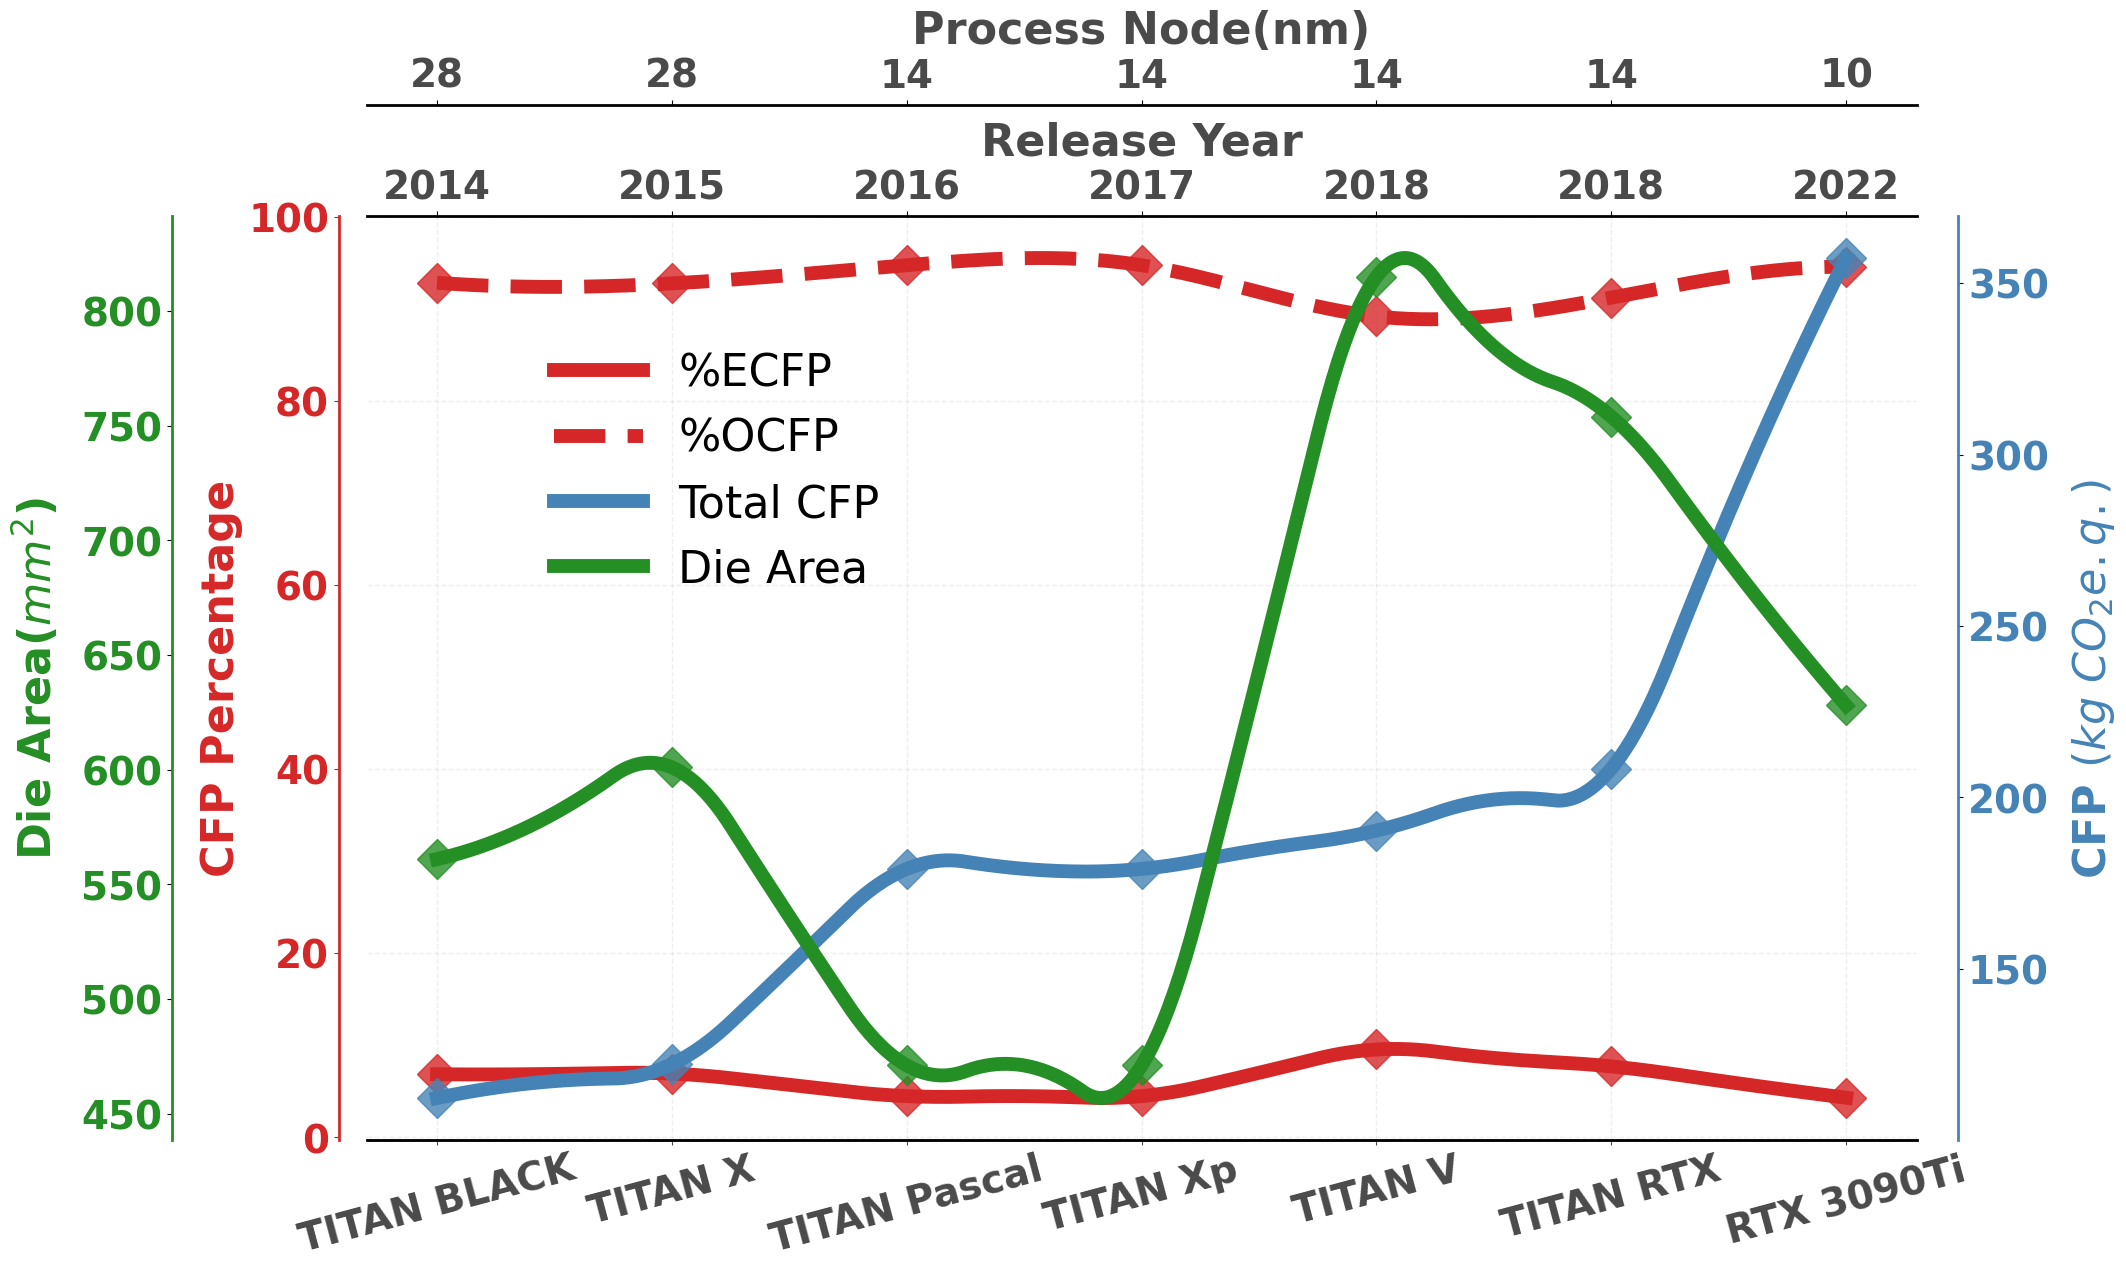

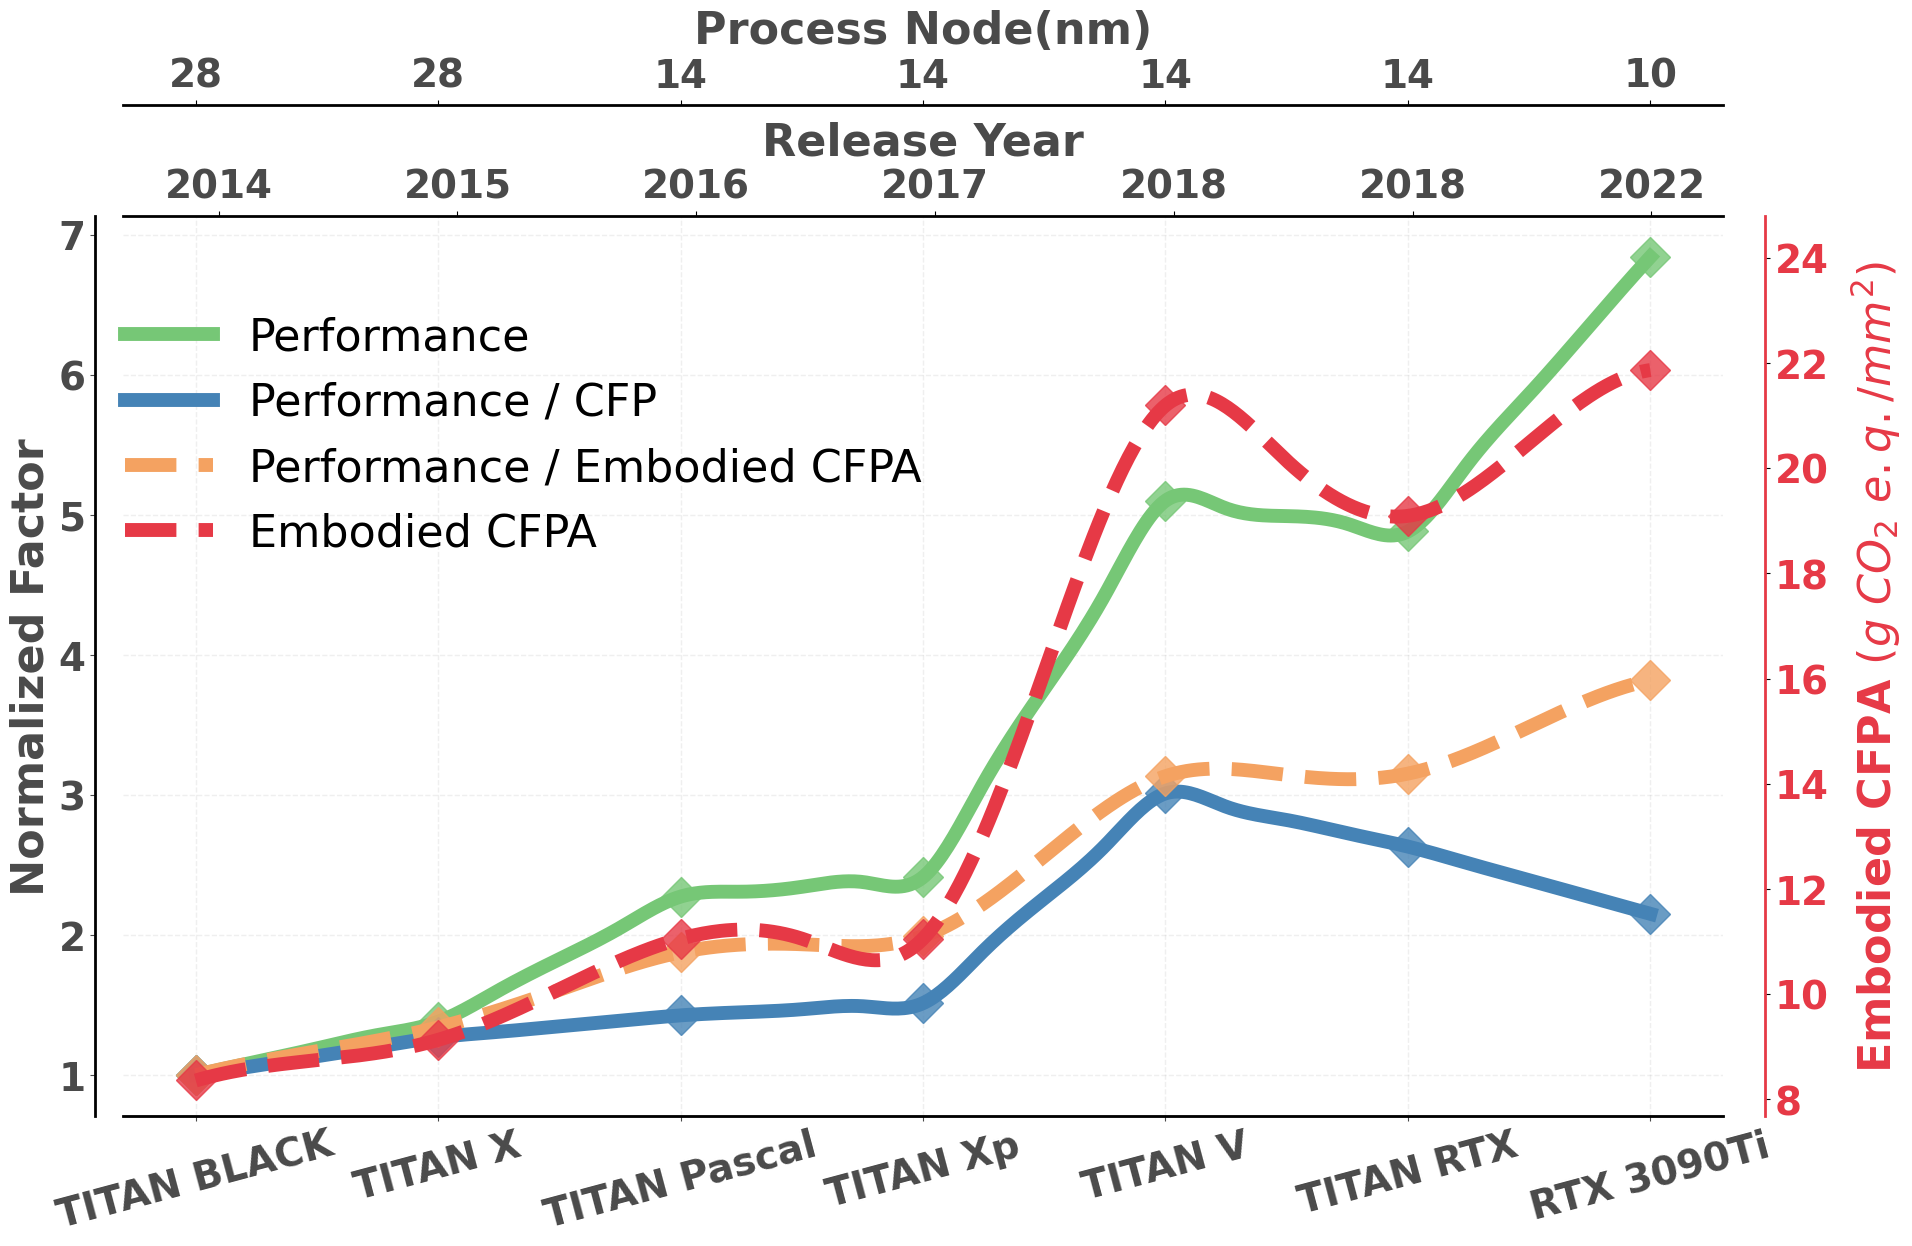

In [10]:
desktop_chip_metrics_plot = chip_metrics_plot(nv, server = False)
desktop_perf_fig = performance_metric_plot(nv, server = False)

In [11]:
desktop_chip_metrics_plot.savefig('desktop_GPU_chip_metrics_plot.pdf', dpi=300, bbox_inches='tight')
desktop_perf_fig.savefig('desktop_GPU_performance_metrics_plot.pdf', dpi=300, bbox_inches='tight')

